# Tech Challenge – FIAP (Fase 4)  
## LSTM para prever **fechamento** da ação do Itaú (**ITUB4.SA**) usando `yfinance`

- Coleta de dados com **yfinance**
- Feature engineering (médias móveis, retornos, volatilidade, RSI)
- Preparação de janelas (lookback) para LSTM
- Split temporal: treino / validação / teste (sem *shuffle*)
- Métricas: **MAE, RMSE**
- Salvamento do modelo e do scaler (para deploy em API)



In [2]:
# Instalar dependências no seu ambiente:
# !pip install yfinance tensorflow scikit-learn pandas numpy matplotlib


In [49]:
import numpy as np
import pandas as pd
import yfinance as yf

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow import keras


In [79]:
from src.data_loader import fetch_yahoo_prices

df = fetch_yahoo_prices(
    "PETR4.SA", #"ITUB4.SA",
    start="2021-01-01",
    interval="1d"
)

df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-02-11 13:00:00,28.139999,28.50,27.870001,28.080000,8.066233,61158600
2021-02-12 22:05:00,27.809999,28.49,27.610001,28.440001,8.169646,47801100
2021-02-17 16:00:00,28.520000,29.60,28.129999,29.590000,8.499993,54973400
2021-02-18 13:00:00,30.379999,30.92,29.040001,29.270000,8.408071,105539200
2021-02-19 13:00:00,28.030001,28.49,27.170000,27.330000,7.850788,215834800


In [80]:
'''# 1) Coleta de dados (yfinance)
TICKER = "ITUB4.SA"
START = "2024-01-01"
END = None         # None = até hoje
INTERVAL = "1d"    # diário

df = yf.download(TICKER, start=START, end=END, interval=INTERVAL, auto_adjust=False, progress=False)
if df is None or df.empty:
    raise ValueError(f"Nenhum dado retornado para {TICKER}. Verifique ticker/período.")
df = df.dropna()
df.head()
'''

'# 1) Coleta de dados (yfinance)\nTICKER = "ITUB4.SA"\nSTART = "2024-01-01"\nEND = None         # None = até hoje\nINTERVAL = "1d"    # diário\n\ndf = yf.download(TICKER, start=START, end=END, interval=INTERVAL, auto_adjust=False, progress=False)\nif df is None or df.empty:\n    raise ValueError(f"Nenhum dado retornado para {TICKER}. Verifique ticker/período.")\ndf = df.dropna()\ndf.head()\n'

In [81]:
# 2) Feature engineering (adaptado para prever RETORNO)

def rsi_wilder(close: pd.Series, period: int = 14) -> pd.Series:
    """
    Calcula o RSI (Relative Strength Index) utilizando o método de Wilder.
    Retorna valores no intervalo [0, 100].
    """
    delta = close.diff()
    gain = delta.clip(lower=0)
    loss = (-delta).clip(lower=0)

    # Wilder smoothing (EMA com alpha = 1/period)
    avg_gain = gain.ewm(alpha=1 / period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1 / period, adjust=False).mean()

    rs = avg_gain / (avg_loss + 1e-12)
    return 100 - (100 / (1 + rs))


# Cria um DataFrame de features a partir do DataFrame original (mantém df intacto)
feat = df.copy()

# =========================
# Features baseadas em preço
# =========================

# Médias móveis simples (SMA)
feat["avg_last_21"] = feat["Adj Close"].rolling(window=21).mean()
feat["avg_last_9"]  = feat["Adj Close"].rolling(window=9).mean()

# Retorno simples diário em % (do dia t em relação ao t-1)
feat["simple_returns"] = feat["Adj Close"].pct_change() * 100.0

# Volatilidade dos retornos (em %)
feat["std_last_20_returns"] = feat["simple_returns"].rolling(window=20).std()
feat["std_last_5_returns"]  = feat["simple_returns"].rolling(window=5).std()

# Volatilidade do volume
feat["std_last_5_volume"] = feat["Volume"].rolling(window=5).std()

# RSI (momentum)
feat["rsi"] = rsi_wilder(feat["Adj Close"], period=14)

# =========================
# Target: RETORNO do próximo dia (t+1)
# =========================

# Guarda o close do dia t (pode ser útil depois na inferência para reconstruir preço)
feat["close_t"] = feat["Adj Close"]

# Retorno do próximo dia (t+1) em relação ao dia t:
# y_next_return = (P_{t+1} / P_t - 1)
feat["y_next_return"] = feat["Adj Close"].shift(-1) / feat["Adj Close"] - 1.0

# Retorno % 
feat["y_next_return_pct"] = feat["y_next_return"] * 100.0

# Remove NaNs gerados por rolling/pct_change/shift
feat = feat.dropna().copy()

# Visualiza as últimas linhas para validar features e target
feat.tail()


,Open,High,Low,Close,Adj Close,Volume,avg_last_21,avg_last_9,simple_returns,std_last_20_returns,std_last_5_returns,std_last_5_volume,rsi,close_t,y_next_return,y_next_return_pct
Date,,,,,,,,,,,,,,,,
2026-02-04 13:00:00,37.450001,37.680000,36.970001,37.520000,37.520000,37955800,33.847143,36.852223,-0.159663,1.487455,0.956613,9.924049e+06,81.391398,37.520000,-0.013859,-1.385929
2026-02-05 13:00:00,37.400002,37.610001,36.900002,37.000000,37.000000,35933100,34.188572,37.070001,-1.385929,1.592548,1.002085,8.713113e+06,74.330507,37.000000,-0.009459,-0.945942
2026-02-06 13:00:00,37.209999,37.270000,36.450001,36.650002,36.650002,27681100,34.495715,37.213334,-0.945942,1.646823,0.977743,1.080959e+07,69.932965,36.650002,0.018281,1.828099
2026-02-09 13:00:00,36.660000,37.450001,36.549999,37.320000,37.320000,27089800,34.830000,37.345556,1.828099,1.647018,1.323268,1.217692e+07,73.201449,37.320000,0.000804,0.080383
2026-02-10 13:00:00,37.320000,37.580002,36.910000,37.349998,37.349998,24585300,35.162858,37.346667,0.080383,1.620001,1.237085,5.906688e+06,73.341186,37.349998,0.027042,2.704156


In [82]:
# 3) Definição de X e y (regressão) — prevendo RETORNO (%)

FEATURE_COLS = [
    "Adj Close",
    "Volume",
    "simple_returns",
    "std_last_5_returns",
    "std_last_20_returns",
    "avg_last_9",
    "avg_last_21",
    "rsi"
]

# X = features (entrada do modelo)
X = feat[FEATURE_COLS].values.astype("float32")

# y = target (retorno do próximo dia em %)
# feat["y_next_return_pct"] = (feat["Adj Close"].shift(-1) / feat["Adj Close"] - 1.0) * 100.0
y = feat[["y_next_return_pct"]].values.astype("float32")

len(X), X.shape, y.shape


(1227, (1227, 8), (1227, 1))

In [84]:
# 4) Split temporal + normalização (ajuste feito APENAS no conjunto de treino)

def temporal_split(X, y, train_ratio=0.70, val_ratio=0.15):
    """
    Realiza a divisão temporal dos dados em treino, validação e teste.

    Parâmetros
    ----------
    X : array-like
        Matriz de features ordenadas no tempo (do passado para o futuro).
    y : array-like
        Vetor de targets correspondentes às features.
    train_ratio : float, opcional
        Proporção dos dados destinada ao conjunto de treino.
    val_ratio : float, opcional
        Proporção dos dados destinada ao conjunto de validação.

    Retorno
    -------
    (X_train, y_train), (X_val, y_val), (X_test, y_test)
        Tuplas contendo os conjuntos de treino, validação e teste.
    """

    # Número total de amostras
    n = len(X)

    # Tamanho do conjunto de treino
    n_train = int(n * train_ratio)

    # Tamanho do conjunto de validação
    n_val = int(n * val_ratio)

    # Conjunto de treino: dados mais antigos
    X_train, y_train = X[:n_train], y[:n_train]

    # Conjunto de validação: dados imediatamente após o treino
    X_val, y_val = X[n_train:n_train + n_val], y[n_train:n_train + n_val]

    # Conjunto de teste: dados mais recentes (nunca vistos pelo modelo)
    X_test, y_test = X[n_train + n_val:], y[n_train + n_val:]

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)


# Aplica o split temporal aos dados
(X_train, y_train), (X_val, y_val), (X_test, y_test) = temporal_split(X, y)

"""# Inicializa os normalizadores Min-Max para features (X) e target (y)
# Cada scaler será ajustado SOMENTE com os dados de treino
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

# Normalização das features:
# - fit_transform é aplicado nos dados de treino (evita vazamento de informação)
# - transform nos conjuntos de validação e teste
X_train_s = x_scaler.fit_transform(X_train)
X_val_s   = x_scaler.transform(X_val)
X_test_s  = x_scaler.transform(X_test)

# Normalização do target:
# - fit_transform apenas no treino
# - transform nos demais conjuntos
y_train_s = y_scaler.fit_transform(y_train)
y_val_s   = y_scaler.transform(y_val)
y_test_s  = y_scaler.transform(y_test)

# Exibe as dimensões dos dados normalizados de treino
X_train_s.shape, y_train_s.shape"""


# X escalado em MinMax(-1,1)
x_scaler = MinMaxScaler(feature_range=(-1, 1))

# y: Aplicado StandardScaler quando saída da rede é linear
y_scaler = StandardScaler()

X_train_s = x_scaler.fit_transform(X_train)
X_val_s   = x_scaler.transform(X_val)
X_test_s  = x_scaler.transform(X_test)

y_train_s = y_scaler.fit_transform(y_train)
y_val_s   = y_scaler.transform(y_val)
y_test_s  = y_scaler.transform(y_test)



In [85]:
print("y_train raw min/max:", float(y_train.min()), float(y_train.max()))
print("y_train_s min/max:", float(y_train_s.min()), float(y_train_s.max()))
#print("y_scaler min/max:", y_scaler.data_min_, y_scaler.data_max_)
print("X_train_s min/max:", float(X_train_s.min()), float(X_train_s.max()))

y_train raw min/max: -9.199352264404297 7.9865803718566895
y_train_s min/max: -4.296165466308594 3.5581681728363037
X_train_s min/max: -1.0 1.0000001192092896


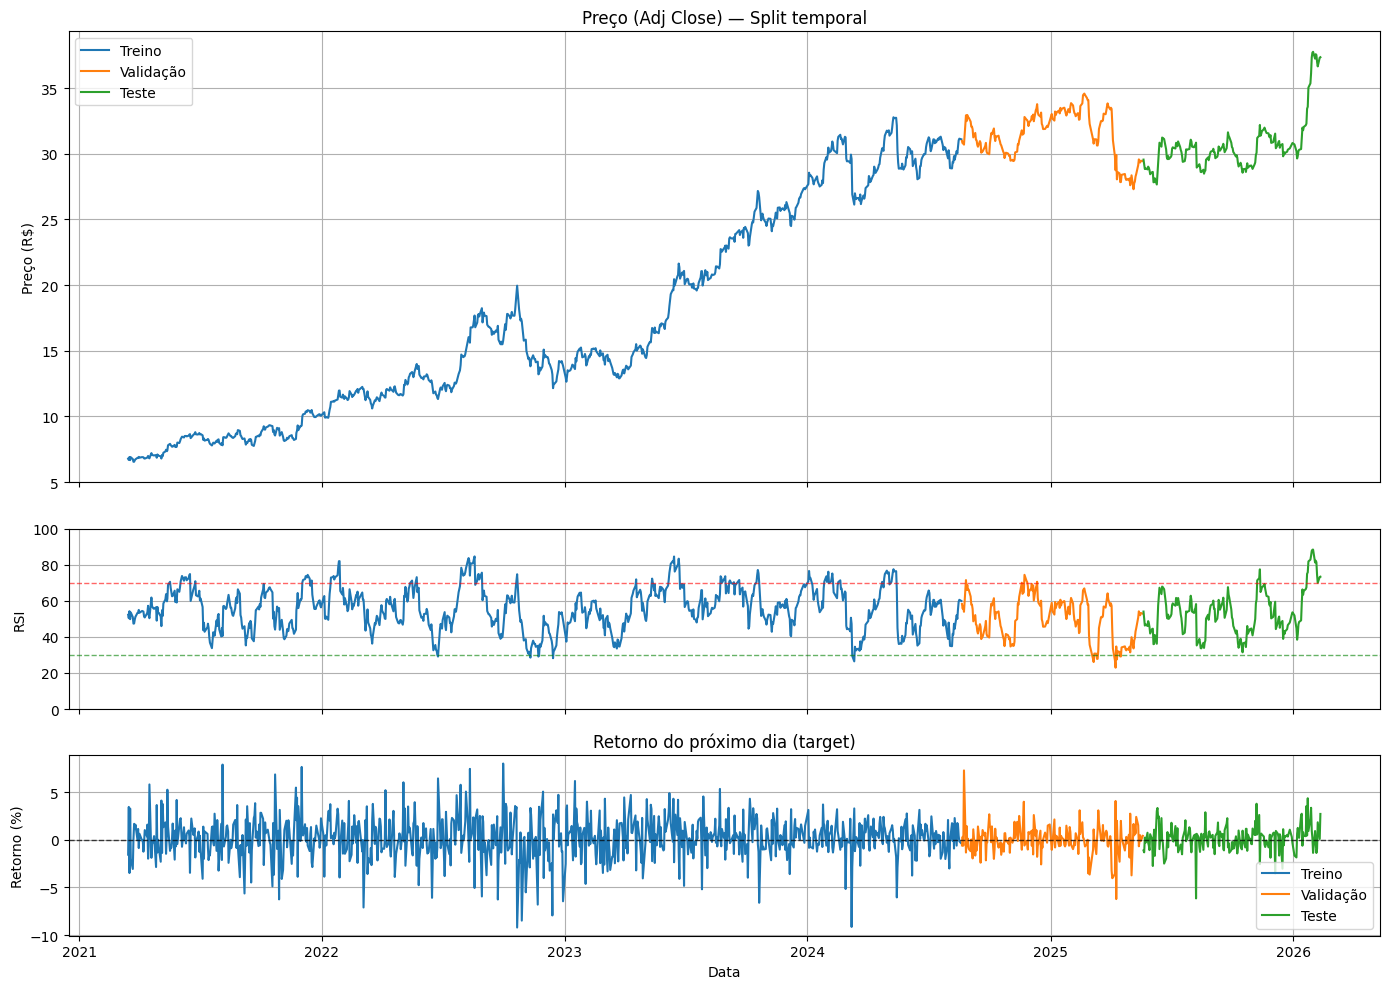

In [86]:
# =========================
# Séries RAW (visualização)
# =========================
price_series = feat["Adj Close"].copy()
rsi_series   = feat["rsi"].copy()
ret_series   = feat["y_next_return_pct"].copy()

# =========================
# Split temporal
# =========================
n = len(feat)
n_train = int(n * 0.70)
n_val   = int(n * 0.15)

idx_train = feat.index[:n_train]
idx_val   = feat.index[n_train:n_train + n_val]
idx_test  = feat.index[n_train + n_val:]

# =========================
# Figura com 3 subplots
# =========================
fig, (ax1, ax2, ax3) = plt.subplots(
    3, 1, figsize=(14, 10), sharex=True,
    gridspec_kw={"height_ratios": [3, 1.2, 1.2]}
)

# =========================
# Gráfico 1: Preço (Adj Close)
# =========================
ax1.plot(idx_train, price_series.loc[idx_train], label="Treino", color="tab:blue")
ax1.plot(idx_val,   price_series.loc[idx_val],   label="Validação", color="tab:orange")
ax1.plot(idx_test,  price_series.loc[idx_test],  label="Teste", color="tab:green")

ax1.set_title("Preço (Adj Close) — Split temporal")
ax1.set_ylabel("Preço (R$)")
ax1.legend()
ax1.grid(True)

# =========================
# Gráfico 2: RSI (período completo)
# =========================
ax2.plot(idx_train, rsi_series.loc[idx_train], color="tab:blue")
ax2.plot(idx_val,   rsi_series.loc[idx_val],   color="tab:orange")
ax2.plot(idx_test,  rsi_series.loc[idx_test],  color="tab:green")

ax2.axhline(70, linestyle="--", linewidth=1, color="red", alpha=0.6)
ax2.axhline(30, linestyle="--", linewidth=1, color="green", alpha=0.6)

ax2.set_ylabel("RSI")
ax2.set_ylim(0, 100)
ax2.grid(True)

# =========================
# Gráfico 3: Retorno alvo (y_next_return_pct)
# =========================
ax3.plot(idx_train, ret_series.loc[idx_train], label="Treino", color="tab:blue")
ax3.plot(idx_val,   ret_series.loc[idx_val],   label="Validação", color="tab:orange")
ax3.plot(idx_test,  ret_series.loc[idx_test],  label="Teste", color="tab:green")

ax3.axhline(0, linestyle="--", linewidth=1, color="black", alpha=0.7)

ax3.set_title("Retorno do próximo dia (target)")
ax3.set_ylabel("Retorno (%)")
ax3.set_xlabel("Data")
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()


In [87]:
"""# 5) Criação de janelas (lookback) para LSTM
def make_windows(X_scaled, y_scaled, lookback: int, name: str = ""):
    """
    Cria janelas temporais (sliding windows) para treinamento de modelos LSTM.

    Espera receber X_scaled e y_scaled já NORMALIZADOS (ex.: MinMaxScaler).
    """

    # Converte para numpy
    X_scaled = np.asarray(X_scaled, dtype=np.float32)
    y_scaled = np.asarray(y_scaled, dtype=np.float32)

    # Garante y em formato (n, 1)
    if y_scaled.ndim == 1:
        y_scaled = y_scaled.reshape(-1, 1)

    # Valida shapes
    if X_scaled.ndim != 2:
        raise ValueError(f"{name}X_scaled deve ser 2D (n_amostras, n_features). Shape: {X_scaled.shape}")
    if y_scaled.ndim != 2 or y_scaled.shape[1] != 1:
        raise ValueError(f"{name}y_scaled deve ser 2D (n_amostras, 1). Shape: {y_scaled.shape}")
    if len(X_scaled) != len(y_scaled):
        raise ValueError(f"{name}X e y devem ter o mesmo tamanho. X={len(X_scaled)} y={len(y_scaled)}")
        
    # (em MinMaxScaler, normalmente fica em ~0–1, podendo exceder 1 no teste)
    if y_scaled.max() > 5 or y_scaled.min() < -1:
        raise ValueError(
            f"{name}y_scaled parece NÃO normalizado (min={y_scaled.min():.3f}, max={y_scaled.max():.3f}). "
            "Você provavelmente passou y_test em vez de y_test_s."
        )

    Xw, yw = [], []

    # Cria janelas
    for i in range(lookback, len(X_scaled)):
        Xw.append(X_scaled[i - lookback:i, :])  # (lookback, n_features)
        yw.append(y_scaled[i, 0])               # escalar

    Xw = np.array(Xw, dtype=np.float32)
    yw = np.array(yw, dtype=np.float32).reshape(-1, 1)

    return Xw, yw


# Tamanho da janela temporal (lookback)
LOOKBACK = 10

# Criação das janelas para treino, validação e teste (IMPORTANTE: sempre usar *_s)
Xtr, ytr = make_windows(X_train_s, y_train_s, LOOKBACK, name="train_")
Xva, yva = make_windows(X_val_s,   y_val_s,   LOOKBACK, name="val_")
Xte, yte = make_windows(X_test_s,  y_test_s,  LOOKBACK, name="test_")

# Verifica shapes finais
print("Xtr:", Xtr.shape, "ytr:", ytr.shape)
print("Xva:", Xva.shape, "yva:", yva.shape)
print("Xte:", Xte.shape, "yte:", yte.shape)

# Verifica ranges (devem estar próximos de 0-1; teste pode exceder 1)
print("ytr min/max:", float(ytr.min()), float(ytr.max()))
print("yte min/max:", float(yte.min()), float(yte.max()))
"""

IndentationError: unexpected indent (4020883360.py, line 4)

In [88]:
# 5) Criação de janelas (lookback) para LSTM
def make_windows(X_scaled, y_scaled, lookback: int):
    """
    Cria janelas temporais (sliding windows) para treinamento de modelos LSTM.

    Parâmetros
    ----------
    X_scaled : array-like (numpy array ou pandas DataFrame)
        Features já normalizadas, no formato (n_amostras, n_features).
    y_scaled : array-like (numpy array ou pandas Series/DataFrame)
        Target já normalizado, no formato (n_amostras,) ou (n_amostras, 1).
    lookback : int
        Número de passos temporais anteriores utilizados como entrada.

    Retorno
    -------
    Xw : np.ndarray
        Array 3D no formato (n_janelas, lookback, n_features),
        compatível com entrada de LSTM.
    yw : np.ndarray
        Array 2D no formato (n_janelas, 1), correspondente ao target futuro.
    """

    # Garante que X e y sejam numpy arrays
    X_scaled = np.asarray(X_scaled, dtype=np.float32)
    y_scaled = np.asarray(y_scaled, dtype=np.float32)

    # Garante que y tenha shape (n, 1)
    if y_scaled.ndim == 1:
        y_scaled = y_scaled.reshape(-1, 1)

    Xw, yw = [], []

    # Criação das janelas temporais
    for i in range(lookback, len(X_scaled)):
        # Janela de entrada: dados do tempo (i-lookback) até (i-1)
        Xw.append(X_scaled[i - lookback:i, :])

        # Target associado: valor do tempo i
        yw.append(y_scaled[i, 0])

    # Converte listas em arrays numpy
    Xw = np.array(Xw, dtype=np.float32)
    yw = np.array(yw, dtype=np.float32).reshape(-1, 1)

    return Xw, yw


# Tamanho da janela temporal (lookback)
LOOKBACK = 10

# Criação das janelas para treino, validação e teste
Xtr, ytr = make_windows(X_train_s, y_train_s, LOOKBACK)
Xva, yva = make_windows(X_val_s,   y_val_s,   LOOKBACK)
Xte, yte = make_windows(X_test_s,  y_test_s,  LOOKBACK)

# Verifica shapes finais
Xtr.shape, ytr.shape, Xte.shape


((848, 10, 8), (848, 1), (175, 10, 8))

In [89]:
# ==========================================================
# 6) Modelo LSTM (regressão para previsão de RETORNO diário)
# ==========================================================

# Número de features por timestep.
# Xtr tem formato: (n_amostras, LOOKBACK, n_features)
# Portanto, a terceira dimensão representa quantas variáveis
# são usadas em cada passo temporal (RSI, médias móveis, etc.).
n_features = Xtr.shape[2]

# ----------------------------------------------------------
# Definição do modelo sequencial
# ----------------------------------------------------------
# Estamos usando uma arquitetura LSTM empilhada para capturar
# dependências temporais nos dados financeiros.
model = keras.Sequential([

    # ------------------------------------------------------
    # Camada de entrada
    # ------------------------------------------------------
    # Cada amostra é uma sequência temporal com:
    # - LOOKBACK dias anteriores
    # - n_features variáveis em cada dia
    #
    # Formato de entrada esperado:
    # (batch_size, LOOKBACK, n_features)
    keras.layers.Input(shape=(LOOKBACK, n_features)),

    # ------------------------------------------------------
    # Primeira camada LSTM
    # ------------------------------------------------------
    # - 64 unidades (neurônios recorrentes)
    # - return_sequences=True mantém a sequência completa
    #   como saída, permitindo empilhar outra LSTM.
    #
    # Essa camada aprende padrões temporais de curto/médio prazo.
    keras.layers.LSTM(64, return_sequences=True),

    # Dropout:
    # - Desativa aleatoriamente 10% dos neurônios durante o treino
    # - Ajuda a reduzir overfitting (importante em séries financeiras)
    keras.layers.Dropout(0.1),

    # ------------------------------------------------------
    # Segunda camada LSTM
    # ------------------------------------------------------
    # - 32 unidades
    # - return_sequences=False (padrão)
    #   → retorna apenas o último estado oculto
    #
    # Esse último estado resume toda a informação temporal
    # da sequência de LOOKBACK dias.
    keras.layers.LSTM(64),

    # Dropout adicional para regularização
    keras.layers.Dropout(0.1),

    # ------------------------------------------------------
    # Camada densa final (saída)
    # ------------------------------------------------------
    # - 1 neurônio → previsão do retorno do próximo dia
    #
    # Ativação linear:
    # - Não impõe limites artificiais
    # - Permite prever retornos negativos e positivos
    # - Adequado para regressão contínua
    keras.layers.Dense(1, activation="linear")
])

# ----------------------------------------------------------
# Compilação do modelo
# ----------------------------------------------------------
# Otimizador:
# - Adam com learning rate 0.002
# - Boa escolha padrão para redes recorrentes
#
# Função de perda:
# - Huber Loss
#   * Quadrática para erros pequenos (como MSE)
#   * Linear para erros grandes (como MAE)
#   * Mais robusta a outliers (muito comuns em retornos financeiros)
#
# O parâmetro delta define o ponto de transição
# entre comportamento MSE e MAE.
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=2e-3),
    loss=keras.losses.Huber(delta=1.0)
)

# Exibe resumo da arquitetura
model.summary()


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                       │ (None, 10, 64)              │          18,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_19 (LSTM)                       │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,777 (202.25 KB)

 Trainable params: 51,777 (202.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.3944 - val_loss: 0.1944 - learning_rate: 0.0020
Epoch 2/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3881 - val_loss: 0.1948 - learning_rate: 0.0020
Epoch 3/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3885 - val_loss: 0.2017 - learning_rate: 0.0020
Epoch 4/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3893 - val_loss: 0.2020 - learning_rate: 0.0020
Epoch 5/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3878 - val_loss: 0.1989 - learning_rate: 0.0020
Epoch 6/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3869 - val_loss: 0.1889 - learning_rate: 0.0020
Epoch 7/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3883 - val_loss: 0.1884 - learning_rate: 0.0020
Epoch 8/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3853 - val_loss: 0.1863 - learning_rate: 0.0020
Epoch 9/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3874 - val_loss: 0.2196 - learning_rate: 0.0020
Epoch 10/80
27/27 ━

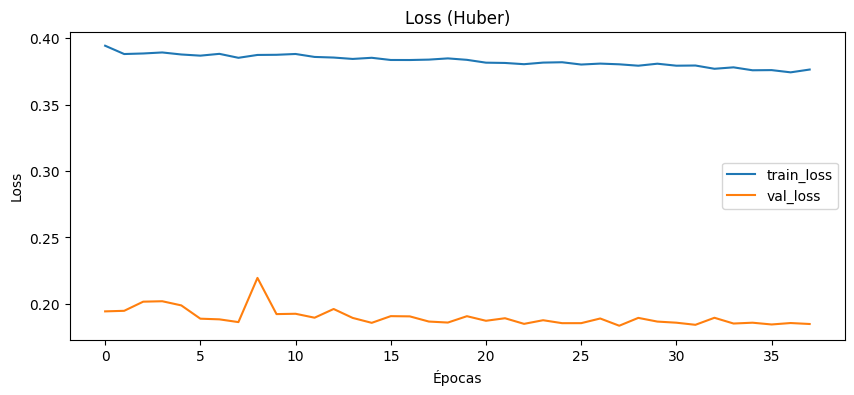

In [90]:
# ==========================================================
# 7) Treinamento do modelo
# ==========================================================

# ----------------------------------------------------------
# Callbacks (mecanismos automáticos de controle do treino)
# ----------------------------------------------------------
callbacks = [

    # EarlyStopping:
    # - Monitora a métrica de validação (val_loss)
    # - Se não houver melhora por 'patience' épocas consecutivas,
    #   o treinamento é interrompido.
    #
    # restore_best_weights=True:
    # - Após parar o treino, restaura os pesos da época
    #   que obteve o menor val_loss.
    #
    # Isso evita overfitting, algo muito comum
    # em séries financeiras (que têm muito ruído).
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True
    ),

    # ReduceLROnPlateau:
    # - Também monitora val_loss
    # - Se não houver melhora por 'patience' épocas,
    #   reduz a taxa de aprendizado.
    #
    # factor=0.5:
    # - Multiplica o learning rate por 0.5
    #
    # Isso ajuda o modelo a:
    # - Sair de platôs
    # - Fazer ajustes mais finos
    # - Melhorar convergência final
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=5
    ),
]

# ----------------------------------------------------------
# Treinamento
# ----------------------------------------------------------
history = model.fit(

    # Dados de treino (janelas temporais)
    Xtr, ytr,

    # Dados de validação (usados para monitorar generalização)
    validation_data=(Xva, yva),

    # Número máximo de épocas
    # O EarlyStopping pode interromper antes
    epochs=80,

    # Batch size:
    # - Número de amostras processadas antes de atualizar os pesos
    batch_size=32,

    # Lista de callbacks definidos acima
    callbacks=callbacks,

    # verbose=1:
    # - Exibe progresso do treinamento a cada época
    verbose=1
)

# ----------------------------------------------------------
# Visualização da evolução da loss
# ----------------------------------------------------------
plt.figure(figsize=(10,4))

# Loss no conjunto de treino
plt.plot(history.history["loss"], label="train_loss")

# Loss no conjunto de validação
plt.plot(history.history["val_loss"], label="val_loss")

plt.legend()
plt.title("Loss (Huber)")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.show()


MAE (p.p.): 1.017141342163086
RMSE (p.p.): 1.3985987901687622
Directional Accuracy: 0.56


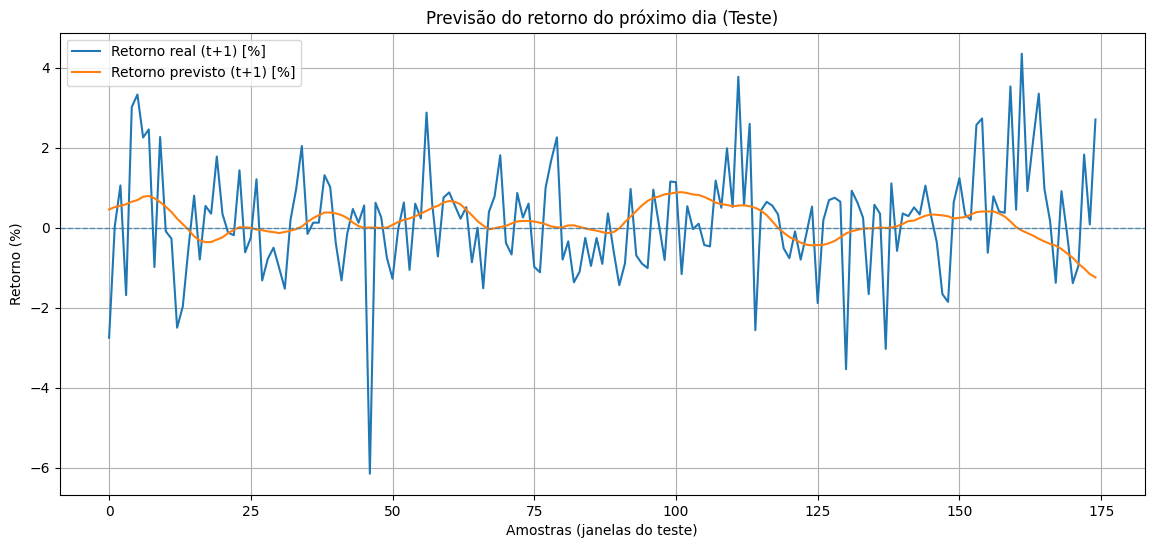

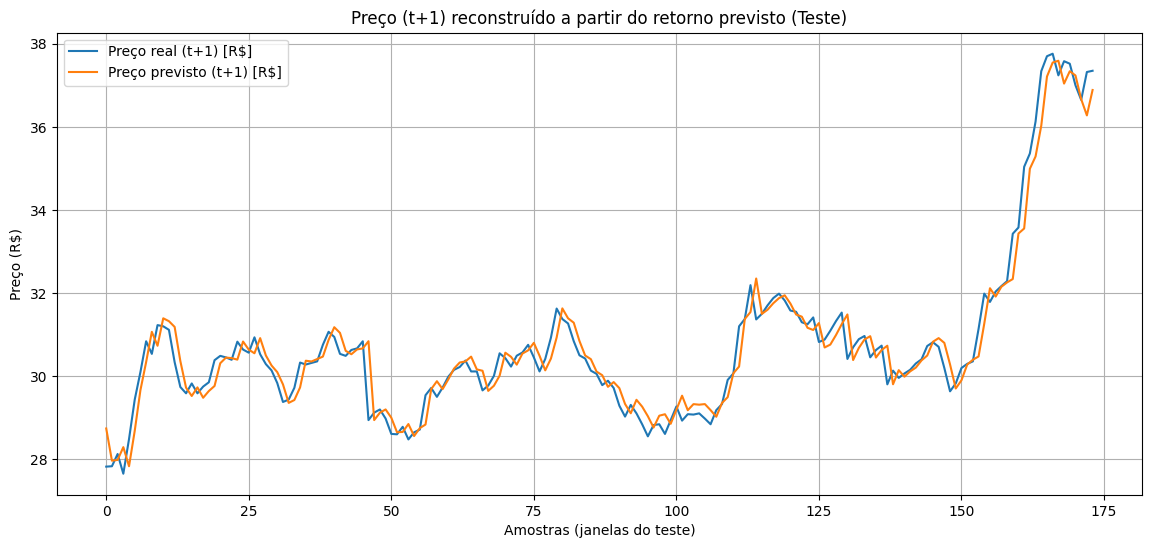

In [91]:
# 1) Predição (scaled)
y_pred_s = model.predict(Xte, verbose=0).astype("float32")

# 2) Desnormaliza para retorno (%)
y_true_ret_pct = y_scaler.inverse_transform(yte).reshape(-1)
y_pred_ret_pct = y_scaler.inverse_transform(y_pred_s).reshape(-1)

print("MAE (p.p.):", float(mae(y_true_ret_pct, y_pred_ret_pct)))
print("RMSE (p.p.):", float(rmse(y_true_ret_pct, y_pred_ret_pct)))

direction_acc = np.mean(np.sign(y_true_ret_pct) == np.sign(y_pred_ret_pct))
print("Directional Accuracy:", float(direction_acc))

# 3) Plot retornos
plt.figure(figsize=(14, 6))
plt.plot(y_true_ret_pct, label="Retorno real (t+1) [%]")
plt.plot(y_pred_ret_pct, label="Retorno previsto (t+1) [%]")
plt.axhline(0, linestyle="--", linewidth=1, alpha=0.7)
plt.title("Previsão do retorno do próximo dia (Teste)")
plt.xlabel("Amostras (janelas do teste)")
plt.ylabel("Retorno (%)")
plt.legend()
plt.grid(True)
plt.show()

# 4) Reconstrução de preço (t+1)
n = len(feat)
n_train = int(n * 0.70)
n_val   = int(n * 0.15)
test_start = n_train + n_val
pred_start = test_start + LOOKBACK

# fatiar com tamanho exato do y
idx_pred = feat.index[pred_start : pred_start + len(y_true_ret_pct)]

price_t = feat.loc[idx_pred, "Adj Close"].values.reshape(-1)
price_true_t1 = feat["Adj Close"].shift(-1).loc[idx_pred].values.reshape(-1)

price_pred_t1 = price_t * (1.0 + (y_pred_ret_pct / 100.0))

# remover NaNs do shift(-1)
valid = ~np.isnan(price_true_t1)
price_true_t1 = price_true_t1[valid]
price_pred_t1 = price_pred_t1[valid]

plt.figure(figsize=(14, 6))
plt.plot(price_true_t1, label="Preço real (t+1) [R$]")
plt.plot(price_pred_t1, label="Preço previsto (t+1) [R$]")
plt.title("Preço (t+1) reconstruído a partir do retorno previsto (Teste)")
plt.xlabel("Amostras (janelas do teste)")
plt.ylabel("Preço (R$)")
plt.legend()
plt.grid(True)
plt.show()


In [92]:
import os, json
import joblib

#TICKER = "ITUB4.SA"
TICKER = "PETR4.SA"
TARGET_TYPE = "return"

#ARTIFACT_DIR = "artifacts_itub4_return"
ARTIFACT_DIR = "artifacts_PETR4_return"

os.makedirs(ARTIFACT_DIR, exist_ok=True)

# Save model
model_path = os.path.join(ARTIFACT_DIR, "best_model.keras")
model.save(model_path)

# Save scalers (works for StandardScaler, MinMaxScaler, RobustScaler, etc.)
joblib.dump(x_scaler, os.path.join(ARTIFACT_DIR, "x_scaler.joblib"))
joblib.dump(y_scaler, os.path.join(ARTIFACT_DIR, "y_scaler.joblib"))

# Metrics (MAPE not recommended for returns)
metrics = {
    "ticker": TICKER,
    "target": TARGET_TYPE,
    "lookback": int(LOOKBACK),
    "features": list(FEATURE_COLS),
    "MAE_pp": float(mae(y_true_ret_pct, y_pred_ret_pct)),
    "RMSE_pp": float(rmse(y_true_ret_pct, y_pred_ret_pct)),
    "DirectionalAccuracy": float(np.mean(np.sign(y_true_ret_pct) == np.sign(y_pred_ret_pct))),
}

with open(os.path.join(ARTIFACT_DIR, "metrics.json"), "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)

print("Modelo de RETORNO salvo em:", ARTIFACT_DIR)
print(metrics)


Modelo de RETORNO salvo em: artifacts_PETR4_return
{'ticker': 'PETR4.SA', 'target': 'return', 'lookback': 10, 'features': ['Adj Close', 'Volume', 'simple_returns', 'std_last_5_returns', 'std_last_20_returns', 'avg_last_9', 'avg_last_21', 'rsi'], 'MAE_pp': 1.017141342163086, 'RMSE_pp': 1.3985987901687622, 'DirectionalAccuracy': 0.56}


Artifacts: artifacts_PETR4_return
LOOKBACK: 10
FEATURES: ['Adj Close', 'Volume', 'simple_returns', 'std_last_5_returns', 'std_last_20_returns', 'avg_last_9', 'avg_last_21', 'rsi']

=== Backtest (2015+) ===
Retorno (%): MAE=8.8716 p.p. | RMSE=12.0283 p.p. | MAPE_safe=134.83%
Preço (R$):  MAE=1.0878     | RMSE=1.6376     | MAPE=8.62%

=== Estratégia (Long se pred_return_pct > TH) ===
Quantil Q=0.60 -> TH=-0.4581 p.p.
Dias operando: 42 / 104 (40.4%)


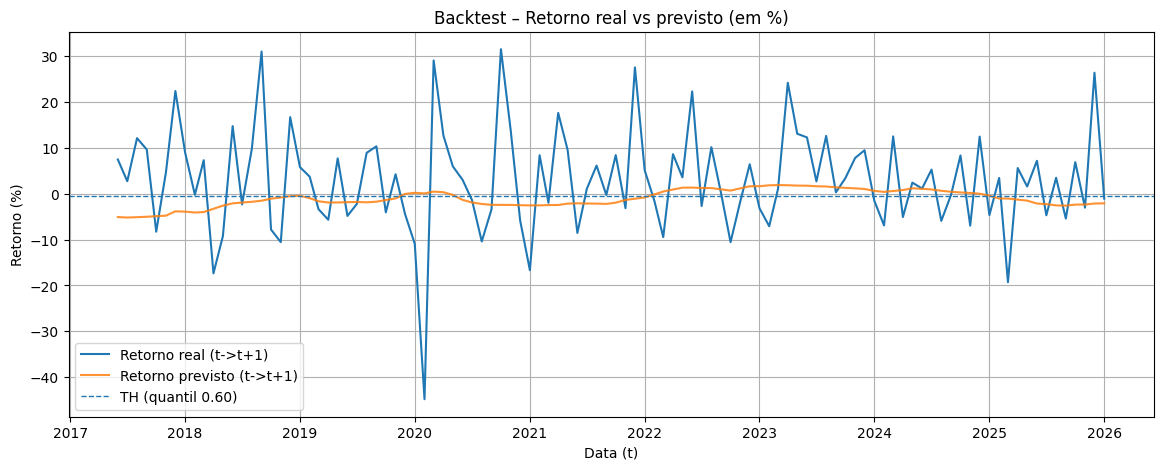

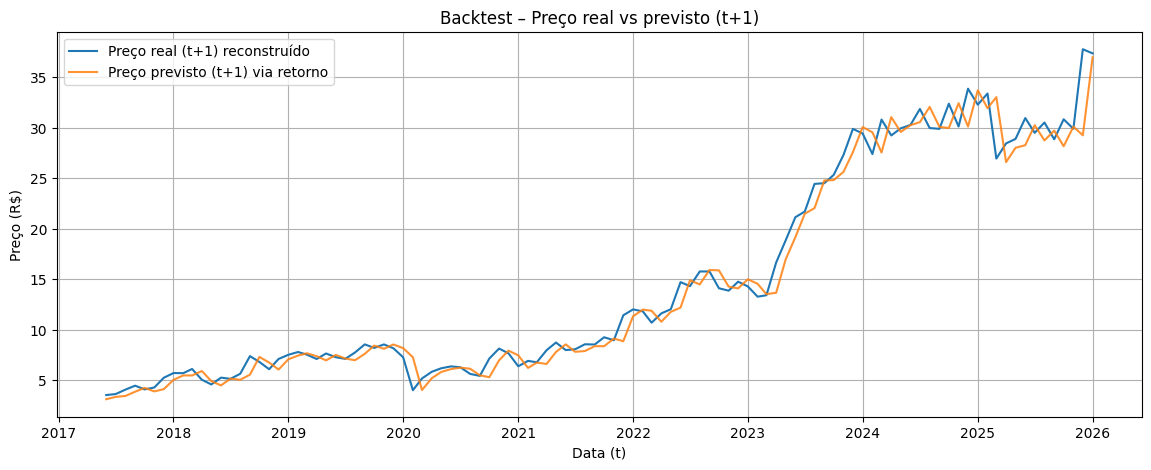

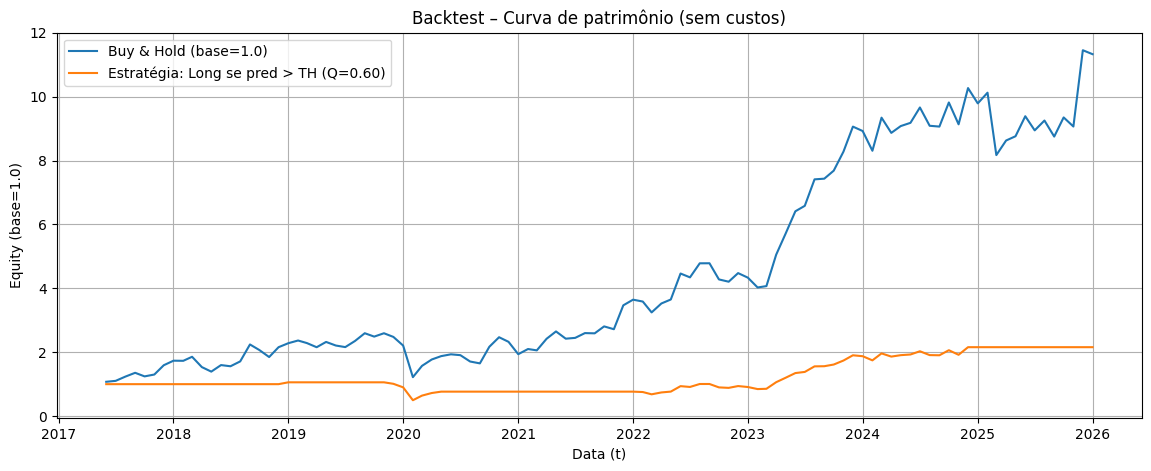

,pred_return_pct,true_return_pct,pred_close_t1,true_close_t1,signal_long,strategy_return_pct,equity_buyhold,equity_strategy
Date_t,,,,,,,,
2025-09-01 03:00:00,-2.616934,-5.435466,29.707554,28.847736,0,-0.0,8.750567,2.157529
2025-10-01 03:00:00,-2.391543,6.857142,28.157830,30.825867,0,0.0,9.350606,2.157529
2025-11-01 03:00:00,-2.363052,-3.051276,30.097436,29.885284,0,-0.0,9.065293,2.157529
2025-12-01 03:00:00,-2.148394,26.349804,29.243231,37.759998,0,0.0,11.453980,2.157529
2026-01-01 03:00:00,-2.109019,-1.085805,36.963633,37.349998,0,-0.0,11.329612,2.157529


In [93]:
# =========================
# BACKTEST (walk-forward) – 2015 em diante (RETORNO -> PREÇO)
# Compatível com StandardScaler / joblib scalers + saída linear + Huber
# =========================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from tensorflow import keras
from src.data_loader import fetch_yahoo_prices

# --- Config ---
#TICKER = "ITUB4.SA"
TICKER = "PETR4.SA"
START_BACKTEST = "2015-01-01"
#ARTIFACT_DIR = os.getenv("ARTIFACT_DIR", "artifacts_itub4_return")
ARTIFACT_DIR = os.getenv("ARTIFACT_DIR", "artifacts_PETR4_return")

# ----------------------------------------------------------
# 1) Carregar artifacts (modelo + scalers + metadados)
# ----------------------------------------------------------
model = keras.models.load_model(os.path.join(ARTIFACT_DIR, "best_model.keras"))

x_scaler = joblib.load(os.path.join(ARTIFACT_DIR, "x_scaler.joblib"))
y_scaler = joblib.load(os.path.join(ARTIFACT_DIR, "y_scaler.joblib"))

# metadados (features/lookback) vindos do metrics.json
import json
with open(os.path.join(ARTIFACT_DIR, "metrics.json"), "r", encoding="utf-8") as f:
    meta = json.load(f)

LOOKBACK = int(meta["lookback"])
FEATURES = list(meta["features"])

print("Artifacts:", ARTIFACT_DIR)
print("LOOKBACK:", LOOKBACK)
print("FEATURES:", FEATURES)

# ----------------------------------------------------------
# 2) Features (mesmas do treino)
# ----------------------------------------------------------
def rsi_wilder(close: pd.Series, period: int = 14) -> pd.Series:
    delta = close.diff()
    gain = delta.clip(lower=0)
    loss = (-delta).clip(lower=0)
    avg_gain = gain.ewm(alpha=1 / period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1 / period, adjust=False).mean()
    rs = avg_gain / (avg_loss + 1e-12)
    return 100 - (100 / (1 + rs))

def build_features_from_df(df: pd.DataFrame) -> pd.DataFrame:
    feat = df.copy()
    feat["avg_last_21"] = feat["Adj Close"].rolling(window=21).mean()
    feat["avg_last_9"]  = feat["Adj Close"].rolling(window=9).mean()

    feat["simple_returns"] = feat["Adj Close"].pct_change() * 100.0
    feat["std_last_20_returns"] = feat["simple_returns"].rolling(window=20).std()
    feat["std_last_5_returns"]  = feat["simple_returns"].rolling(window=5).std()
    feat["std_last_5_volume"]   = feat["Volume"].rolling(window=5).std()

    feat["rsi"] = rsi_wilder(feat["Adj Close"], period=14)

    # retorno real do próximo dia (t->t+1) em %
    feat["y_next_return_pct"] = (feat["Adj Close"].shift(-1) / feat["Adj Close"] - 1.0) * 100.0

    return feat.dropna().copy()

# ----------------------------------------------------------
# 3) Métricas
# ----------------------------------------------------------
def mae(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return float(np.mean(np.abs(y_true - y_pred)))

def rmse(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

def mape_safe(y_true, y_pred, eps=0.10):
    """
    MAPE para retornos em % (p.p.), evitando explodir perto de 0.
    eps=0.10 => denom mínimo 0.10 p.p. (0.10%).
    """
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    denom = np.maximum(np.abs(y_true), eps)
    return float(np.mean(np.abs((y_true - y_pred) / denom)) * 100.0)

# ----------------------------------------------------------
# 4) Baixar histórico
# ----------------------------------------------------------
df_raw = fetch_yahoo_prices(
    symbol=TICKER,
    start=START_BACKTEST,
    range_="max",
    interval="1d",
    tries=10
)[["Adj Close", "Volume"]].dropna().copy()

# 5) Gerar features
feat = build_features_from_df(df_raw)

# ----------------------------------------------------------
# 6) Walk-forward backtest
# ----------------------------------------------------------
pred_return_pct_list = []
pred_close_list      = []
true_return_pct_list = []
true_close_list      = []
t_index_list         = []

idx = feat.index

for i in range(LOOKBACK - 1, len(feat) - 1):
    # janela LOOKBACK até o dia t (inclui t)
    window = feat.iloc[i - (LOOKBACK - 1): i + 1]  # LOOKBACK linhas

    # Matriz histórica (LOOKBACK, n_features)
    X_hist = window[FEATURES].values.astype(np.float32)

    # 6.1) Escala X com o scaler do treino
    X_hist_s = x_scaler.transform(X_hist)

    # 6.2) Formato esperado pela LSTM: (1, LOOKBACK, n_features)
    X_in = X_hist_s.reshape(1, LOOKBACK, len(FEATURES))

    # 6.3) Predição do retorno (scaled)
    y_pred_s = model.predict(X_in, verbose=0).astype(np.float32)  # shape (1,1)

    # 6.4) Desescala para retorno em % (original)
    pred_ret_t1 = float(y_scaler.inverse_transform(y_pred_s).reshape(-1)[0])

    # preço em t
    last_close_t = float(window["Adj Close"].iloc[-1])

    # retorno real (t->t+1) em %
    true_ret_t1 = float(feat["y_next_return_pct"].iloc[i])

    # preço real em t+1
    true_close_t1 = float(last_close_t * (1.0 + true_ret_t1 / 100.0))

    # preço previsto em t+1 via retorno previsto
    pred_close_t1 = float(last_close_t * (1.0 + pred_ret_t1 / 100.0))

    pred_return_pct_list.append(pred_ret_t1)
    pred_close_list.append(pred_close_t1)
    true_return_pct_list.append(true_ret_t1)
    true_close_list.append(true_close_t1)
    t_index_list.append(idx[i])  # data do "t"

bt = pd.DataFrame({
    "pred_return_pct": pred_return_pct_list,
    "true_return_pct": true_return_pct_list,
    "pred_close_t1": pred_close_list,
    "true_close_t1": true_close_list,
}, index=pd.DatetimeIndex(t_index_list, name="Date_t"))

# ----------------------------------------------------------
# 7) Métricas do backtest
# ----------------------------------------------------------
mae_ret  = mae(bt["true_return_pct"], bt["pred_return_pct"])
rmse_ret = rmse(bt["true_return_pct"], bt["pred_return_pct"])
mape_ret = mape_safe(bt["true_return_pct"], bt["pred_return_pct"], eps=0.10)

mae_px  = mae(bt["true_close_t1"], bt["pred_close_t1"])
rmse_px = rmse(bt["true_close_t1"], bt["pred_close_t1"])
mape_px = float(np.mean(np.abs((bt["true_close_t1"] - bt["pred_close_t1"]) / (bt["true_close_t1"] + 1e-12))) * 100.0)

print("\n=== Backtest (2015+) ===")
print(f"Retorno (%): MAE={mae_ret:.4f} p.p. | RMSE={rmse_ret:.4f} p.p. | MAPE_safe={mape_ret:.2f}%")
print(f"Preço (R$):  MAE={mae_px:.4f}     | RMSE={rmse_px:.4f}     | MAPE={mape_px:.2f}%")

# ----------------------------------------------------------
# 8) Estratégia (threshold por quantil)
# ----------------------------------------------------------
Q = 0.60
TH = float(bt["pred_return_pct"].quantile(Q))

bt["signal_long"] = (bt["pred_return_pct"] > TH).astype(int)
bt["strategy_return_pct"] = bt["signal_long"] * bt["true_return_pct"]

bt["equity_buyhold"]  = (1.0 + (bt["true_return_pct"] / 100.0)).cumprod()
bt["equity_strategy"] = (1.0 + (bt["strategy_return_pct"] / 100.0)).cumprod()

n_trades = int(bt["signal_long"].sum())
trade_rate = float(bt["signal_long"].mean() * 100.0)

print("\n=== Estratégia (Long se pred_return_pct > TH) ===")
print(f"Quantil Q={Q:.2f} -> TH={TH:.4f} p.p.")
print(f"Dias operando: {n_trades} / {len(bt)} ({trade_rate:.1f}%)")

# ----------------------------------------------------------
# 9) Plots
# ----------------------------------------------------------
plt.figure(figsize=(14, 5))
plt.plot(bt.index, bt["true_return_pct"], label="Retorno real (t->t+1)")
plt.plot(bt.index, bt["pred_return_pct"], label="Retorno previsto (t->t+1)", alpha=0.85)
plt.axhline(TH, linestyle="--", linewidth=1, label=f"TH (quantil {Q:.2f})")
plt.title("Backtest – Retorno real vs previsto (em %)")
plt.xlabel("Data (t)")
plt.ylabel("Retorno (%)")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(bt.index, bt["true_close_t1"], label="Preço real (t+1) reconstruído")
plt.plot(bt.index, bt["pred_close_t1"], label="Preço previsto (t+1) via retorno", alpha=0.85)
plt.title("Backtest – Preço real vs previsto (t+1)")
plt.xlabel("Data (t)")
plt.ylabel("Preço (R$)")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(bt.index, bt["equity_buyhold"], label="Buy & Hold (base=1.0)")
plt.plot(bt.index, bt["equity_strategy"], label=f"Estratégia: Long se pred > TH (Q={Q:.2f})")
plt.title("Backtest – Curva de patrimônio (sem custos)")
plt.xlabel("Data (t)")
plt.ylabel("Equity (base=1.0)")
plt.grid(True)
plt.legend()
plt.show()

bt.tail()


In [94]:
# ============================================================
# DIAGNÓSTICO: Baselines + métricas + hit ratio (direção)
# + Checagem de alinhamento t vs t+1
# ============================================================

import numpy as np
import pandas as pd
import random

# ----------------------------
# 1) Funções de métricas
# ----------------------------
def mae(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return float(np.mean(np.abs(y_true - y_pred)))

def rmse(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

def mape_safe(y_true, y_pred, eps=0.10):
    """
    MAPE para retornos em % (p.p.). Evita explodir quando y_true ~ 0.
    eps=0.10 => denom mínimo 0.10 p.p. (0.10%).
    """
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    denom = np.maximum(np.abs(y_true), eps)
    return float(np.mean(np.abs((y_true - y_pred) / denom)) * 100.0)

def hit_ratio(y_true, y_pred, thr=0.0):
    """
    Acurácia direcional com threshold:
    - Considera "positivo" se > thr, "negativo" se < -thr.
    - Ignora casos com |retorno| <= thr (opcional; útil para retorno ~ 0).
    Retorna hit ratio em % e também a taxa de amostras usadas.
    """
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    mask = (np.abs(y_true) > thr)  # ignora retornos reais muito pequenos
    if mask.sum() == 0:
        return 0.0, 0.0

    yt = np.sign(y_true[mask])
    yp = np.sign(y_pred[mask])

    acc = float(np.mean(yt == yp) * 100.0)
    used = float(mask.mean() * 100.0)
    return acc, used

def mape_price(yt, yp):
    yt = np.asarray(yt).reshape(-1)
    yp = np.asarray(yp).reshape(-1)
    return float(np.mean(np.abs((yt - yp) / (yt + 1e-12))) * 100.0)

def manual_return_pct_from_prices(price_t, price_t1):
    return (price_t1 / price_t - 1.0) * 100.0


# ============================================================
# PARTE A) Baselines vs Modelo (usando bt)
# ============================================================
try:
    y_true_return = bt["true_return_pct"].values.astype(np.float32)
    y_pred_return = bt["pred_return_pct"].values.astype(np.float32)
    last_close_t  = feat.loc[bt.index, "Adj Close"].values.astype(np.float32)
    print("Usando bt (backtest) para comparar baselines.")
except NameError:
    raise NameError(
        "Não encontrei 'bt'. Execute a célula do backtest primeiro "
        "ou adapte esta célula para usar y_true/y_pred do seu teste."
    )

# ---------
# 1) Baselines de retorno (corretos)
# ---------
# Baseline 0% (sempre prevê 0)
ret_pred_zero = np.zeros_like(y_true_return)

# Baseline "persistência do retorno observado" (ontem):
# usamos o retorno REAL observado até t, que é feat["simple_returns"] = retorno (t vs t-1) em %
# e alinhamos pelas datas de bt (que são datas t)
if "simple_returns" not in feat.columns:
    raise ValueError("feat precisa conter a coluna 'simple_returns' (retorno t vs t-1 em %).")

ret_pred_yesterday = feat.loc[bt.index, "simple_returns"].values.astype(np.float32)

# ---------
# 2) Reconstrução de preço (t+1)
# ---------
price_true_t1 = last_close_t * (1.0 + y_true_return / 100.0)

price_pred_t1_model     = last_close_t * (1.0 + y_pred_return / 100.0)
price_pred_t1_zero      = last_close_t * (1.0 + ret_pred_zero / 100.0)        # = last_close_t
price_pred_t1_yesterday = last_close_t * (1.0 + ret_pred_yesterday / 100.0)

# ---------
# 3) Métricas (RETORNO)
# ---------
thr = 0.05  # 0.05 p.p. = 0.05% (ajuste se quiser ignorar micro-retornos)
hit_model, used_model = hit_ratio(y_true_return, y_pred_return, thr=thr)
hit_zero,  used_zero  = hit_ratio(y_true_return, ret_pred_zero, thr=thr)
hit_yday,  used_yday  = hit_ratio(y_true_return, ret_pred_yesterday, thr=thr)

print("\n=== MÉTRICAS (RETORNO % / p.p.) ===")
print(f"MODELO:   MAE={mae(y_true_return,y_pred_return):.4f} | RMSE={rmse(y_true_return,y_pred_return):.4f} | MAPE_safe={mape_safe(y_true_return,y_pred_return):.2f}% | HIT@{thr:.2f}={hit_model:.2f}% (usou {used_model:.1f}%)")
print(f"BASE 0%:  MAE={mae(y_true_return,ret_pred_zero):.4f} | RMSE={rmse(y_true_return,ret_pred_zero):.4f} | MAPE_safe={mape_safe(y_true_return,ret_pred_zero):.2f}% | HIT@{thr:.2f}={hit_zero:.2f}% (usou {used_zero:.1f}%)")
print(f"BASE yday:MAE={mae(y_true_return,ret_pred_yesterday):.4f} | RMSE={rmse(y_true_return,ret_pred_yesterday):.4f} | MAPE_safe={mape_safe(y_true_return,ret_pred_yesterday):.2f}% | HIT@{thr:.2f}={hit_yday:.2f}% (usou {used_yday:.1f}%)")

# Diagnósticos úteis: variância/viés do preditor
print("\n=== DIAGNÓSTICOS DO PREDITOR (RETORNO em %) ===")
print(f"True: mean={float(np.mean(y_true_return)):+.4f} | std={float(np.std(y_true_return)):.4f}")
print(f"Pred: mean={float(np.mean(y_pred_return)):+.4f} | std={float(np.std(y_pred_return)):.4f}")
print(f"Pred (min,max)=({float(np.min(y_pred_return)):+.4f}, {float(np.max(y_pred_return)):+.4f})")
print(f"% dias positivos (true) = {float(np.mean(y_true_return > 0) * 100.0):.2f}%")
print(f"% dias positivos (pred) = {float(np.mean(y_pred_return > 0) * 100.0):.2f}%")

# ---------
# 4) Métricas (PREÇO t+1 reconstruído)
# ---------
print("\n=== MÉTRICAS (PREÇO t+1 reconstruído) ===")
print(f"MODELO:    MAE={mae(price_true_t1,price_pred_t1_model):.4f} | RMSE={rmse(price_true_t1,price_pred_t1_model):.4f} | MAPE={mape_price(price_true_t1,price_pred_t1_model):.2f}%")
print(f"BASE P_t:  MAE={mae(price_true_t1,price_pred_t1_zero):.4f}  | RMSE={rmse(price_true_t1,price_pred_t1_zero):.4f}  | MAPE={mape_price(price_true_t1,price_pred_t1_zero):.2f}%")
print(f"BASE yday: MAE={mae(price_true_t1,price_pred_t1_yesterday):.4f} | RMSE={rmse(price_true_t1,price_pred_t1_yesterday):.4f} | MAPE={mape_price(price_true_t1,price_pred_t1_yesterday):.2f}%")


# ============================================================
# PARTE B) CHECAGEM DE ALINHAMENTO (t vs t+1)
# ============================================================
# Verifica:
# - bt["true_return_pct"] bate com feat["y_next_return_pct"] no mesmo t
# - feat["y_next_return_pct"] bate com o retorno manual calculado de AdjClose(t) e AdjClose(t+1)
# ============================================================

if "y_next_return_pct" not in feat.columns:
    raise ValueError("feat precisa conter a coluna 'y_next_return_pct' (retorno t->t+1 em %).")

sample_dates = random.sample(list(bt.index), k=min(5, len(bt)))

print("\n=== SANITY CHECK (ALINHAMENTO) ===")
for dt in sample_dates:
    # dt é a data t
    p_t = float(feat.loc[dt, "Adj Close"])

    # próximo pregão no feat (t+1)
    pos = feat.index.get_loc(dt)
    if isinstance(pos, slice):
        pos = pos.start
    if pos + 1 >= len(feat.index):
        print(dt, "-> sem t+1 disponível (fim da série)")
        continue

    dt1 = feat.index[pos + 1]
    p_t1 = float(feat.loc[dt1, "Adj Close"])

    ret_manual = manual_return_pct_from_prices(p_t, p_t1)

    ret_feat = float(feat.loc[dt, "y_next_return_pct"])      # target construído
    ret_bt   = float(bt.loc[dt, "true_return_pct"])          # retornos usados no backtest
    ret_pred = float(bt.loc[dt, "pred_return_pct"])

    p_pred_t1 = float(p_t * (1.0 + ret_pred / 100.0))

    print(f"\nData t = {dt.date()} | Data t+1 = {dt1.date()}")
    print(f"AdjClose(t)={p_t:.4f} | AdjClose(t+1)={p_t1:.4f}")
    print(f"Ret manual={ret_manual:+.4f}% | Ret feat={ret_feat:+.4f}% | Ret bt={ret_bt:+.4f}%")
    print(f"Dif feat-manual={ret_feat-ret_manual:+.6f} | Dif bt-feat={ret_bt-ret_feat:+.6f}")
    print(f"Ret previsto={ret_pred:+.4f}% | Preço previsto(t+1)={p_pred_t1:.4f}")

print("\nSe 'Dif feat-manual' ~ 0 e 'Dif bt-feat' ~ 0, o alinhamento t vs t+1 está OK.")
print("Se houver diferença grande, existe bug de shift/janela (trocou t por t+1 em algum ponto).")


Usando bt (backtest) para comparar baselines.

=== MÉTRICAS (RETORNO % / p.p.) ===
MODELO:   MAE=8.8716 | RMSE=12.0283 | MAPE_safe=134.83% | HIT@0.05=49.51% (usou 99.0%)
BASE 0%:  MAE=8.5641 | RMSE=11.5636 | MAPE_safe=99.36% | HIT@0.05=0.00% (usou 99.0%)
BASE yday:MAE=12.9161 | RMSE=16.3587 | MAPE_safe=436.14% | HIT@0.05=43.69% (usou 99.0%)

=== DIAGNÓSTICOS DO PREDITOR (RETORNO em %) ===
True: mean=+3.0013 | std=11.1673
Pred: mean=-1.0322 | std=1.8490
Pred (min,max)=(-5.2025, +1.8662)
% dias positivos (true) = 58.65%
% dias positivos (pred) = 35.58%

=== MÉTRICAS (PREÇO t+1 reconstruído) ===
MODELO:    MAE=1.0878 | RMSE=1.6376 | MAPE=8.62%
BASE P_t:  MAE=1.0816  | RMSE=1.6188  | MAPE=8.40%
BASE yday: MAE=1.7769 | RMSE=2.5674 | MAPE=12.60%

=== SANITY CHECK (ALINHAMENTO) ===

Data t = 2022-06-01 | Data t+1 = 2022-07-01
AdjClose(t)=12.0341 | AdjClose(t+1)=14.7141
Ret manual=+22.2699% | Ret feat=+22.2699% | Ret bt=+22.2699%
Dif feat-manual=+0.000000 | Dif bt-feat=+0.000000
Ret previsto=+